<a href="https://colab.research.google.com/github/HungYangChang/ECSE-551-Mini-project2/blob/main/miniproject2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mini-Project 2

In [ ]:
# Import relevant modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction import text
from sklearn import model_selection
from sklearn import svm
import time
import nltk

# Load and Prepare Data

In [ ]:
# Load testing and training data
url = "https://raw.githubusercontent.com/jonarsenault/ecse551data/master/train.csv"
train_data = pd.read_csv(url)

url = "https://raw.githubusercontent.com/jonarsenault/ecse551data/master/test.csv"
test_data = pd.read_csv(url)

# Parameters
number_of_samples = None  # Set to None to test entire data set
stop_words = text.ENGLISH_STOP_WORDS
np.random.seed(10)

# For some reason, need to shuffle even if using all data
if number_of_samples is None:
    number_of_samples = len(train_data)

train_data = train_data.sample(number_of_samples).reset_index(drop=True)

X = train_data["body"]
y = train_data["subreddit"]

X_test = test_data["body"]

In [ ]:
# Parameters

# Add some stop words
more_stop_words = [
    "u",
    "just",
    "think",
    "https",
    "www",
    "don't",
    "like",
    "need",
    "it",
    "you're",
    "use",
    "reddit",
    "thing",
    "I'm",
    "things",
    "good",
    "really",
    "want",
    "maybe",
    "imgur",
    "com",
    "don",
    "actually",
    "that",
    "make",
    "lot",
    "different",
    "doing",
    "that",
    "better",
    "going",
    "great",
]

fewer_stop_words = [
    "u",
    "just",
    "think",
    "don't",
    "like",
    "need",
    "it",
    "you're",
    "use",
    "thing",
    "I'm",
    "things",
    "good",
    "really",
    "want",
    "maybe",
    "don",
    "actually",
    "that",
    "make",
    "lot",
    "different",
    "doing",
    "that",
    "better",
    "going",
    "great",
]
almost_all_stop_words = stop_words.union(fewer_stop_words)
all_stop_words = stop_words.union(more_stop_words)

# Define our own Naive Bayes class




In [ ]:
class NaiveBayes:
    def __init__(self, alpha=0.01, prior="learn"):
        """Constructor"""

        self.alpha = alpha
        self.prior = prior
    def fit(self, X, y):
        """Obtain naive bayes parameters from training data. X is input data, 
        y are class labels"""

        # Convert sparse array to dense array
        X = X.toarray()

        # Compute each class probability
        class_counts = y.value_counts()

        num_labels = len(class_counts)

        if self.prior == "learn":
          # Learn the class probabilities from the training data
          self.class_probabilities = class_counts / len(y)
        elif self.prior == "uniform":
          # Assume a uniform prior
          self.class_probabilities = pd.Series(np.repeat(1/num_labels, num_labels), 
                                               index = class_counts.index)

        # Sort in alphabetical order
        self.class_probabilities.sort_index(inplace=True)
        class_counts.sort_index(inplace=True)

        # Compute parameters
        features_count = np.empty((num_labels, X.shape[1]))

        y_numpy = y.to_numpy()
        for i in range(num_labels):

            label = self.class_probabilities.index[i]
            X_this_label = X[np.nonzero(y_numpy == label), :]

            features_count[i,:] = np.sum(X_this_label, axis=1)

        # Laplace smoothing
        smoothed_numerator = features_count + self.alpha
        smoothed_denominator = np.sum(smoothed_numerator,axis=1).reshape(-1,1)

        self.parameters = pd.DataFrame(smoothed_numerator / smoothed_denominator, index=self.class_probabilities.index)
        
    def predict(self, X):
        """Predict class of text"""

        X = X.toarray()

        delta = pd.DataFrame(columns=self.class_probabilities.index)
        for label in self.class_probabilities.index:

            # Get probability of currect class P(y=k)
            class_probability = self.class_probabilities[label]

            # Get theta_j for currect class
            theta_j_class = self.parameters.loc[label, :].to_numpy()

            # Compute P(x_j | y = k)
            prob_features_given_y = (theta_j_class ** X) * (1 - theta_j_class) ** (
                1 - X
            )

            # Compute P(x | y = k)
            prob_sample_given_y = np.prod(prob_features_given_y, axis=1)

            # Compute P(y) * P(x | y = k)
            term1 = np.log(class_probability)
            term2 = np.sum(X * np.log(theta_j_class), axis=1)
            term3 = np.sum((1 - X) * np.log(1 - theta_j_class), axis=1)
            delta_k = term1 + term2 + term3

            # Append
            delta[label] = delta_k

        predicted_class = delta.idxmax(axis=1)

        return predicted_class.to_list()

    def score(self, X, y):
        """Compute accuracy of naive bayes model"""      

        y_pred = self.predict(X)

        accuracy = np.count_nonzero(y == y_pred) / len(y_pred)

        return accuracy

    def get_params(self, deep=True):
        """Getter for parameters"""

        params = {"alpha": self.alpha,
                  "prior": self.prior}

        return params

    def set_params(self, **parameters):
        "Setter for parameters"
        for parameter, value in parameters.items():
            setattr(self, parameter, value)

        return self


# Run grid search to determine best parameters for Naive Bayes model

In [ ]:
# After extensive offline testing, it was determined that these are the parameters
# that should be tuned.

# final best result:

# count vectorzier vs TFIDF vectorzier --> choose count vectorzier
# vectorzier stop words --> all stop words
# Lemmatizer or Stemming --> Neither!
# removing stop word --> add more stop words
# N-gram --> None (1,1)
# Chi2 Best K --> k = 30000
# normalizer --> Yes!
# Naive bayes alpha --> 0.01
# Class prior --> uniform!



pipe_params = {
    "vect__stop_words": [None, stop_words, all_stop_words],
    "vect__ngram_range": [(1,1), (1,2), (1,3)],
    "selecter__k":[5000, 15000, 25000],
    "classify__alpha" : [0.001, 0.01, 0.1],
    "classify__prior" : ["uniform", "learn"],
}

vectorizer = CountVectorizer()
selecter = SelectKBest(chi2)
normalizer = Normalizer()
naive_bayes_model = NaiveBayes()

pipe = Pipeline(
    [("vect", vectorizer), ("norm", normalizer), ("selecter", selecter), ("classify", NaiveBayes())]
)

grid = model_selection.GridSearchCV(pipe, pipe_params, verbose=1, n_jobs=-1)

grid.fit(X, y)

print(f"The best accuracy is {grid.best_score_}.")
print(f"The winning parameters are {grid.best_params_}")


Fitting 5 folds for each of 162 candidates, totalling 810 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  4.5min
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 30.9min


KeyboardInterrupt: ignored

# Generate plot of grid search for smoothing parameter

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  2.9min finished


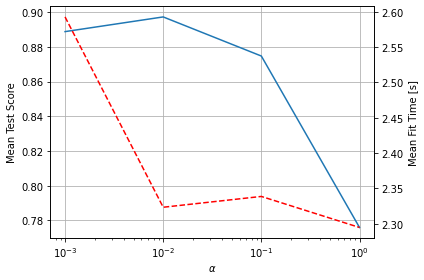

In [ ]:
# Using the best parameters from the more general grid search, a more specific 
# grid search is used to determine the effect of alpha

# Define search parameters
alpha_grid = np.logspace(-3, 0, 4)
pipe_params = {
    "classify__alpha" : alpha_grid,
}

# Create pipeline
vectorizer = CountVectorizer(stop_words=all_stop_words)
selecter = SelectKBest(chi2, k=15000)
normalizer = Normalizer()
naive_bayes_model = NaiveBayes(prior="uniform")

pipe = Pipeline(
    [("vect", vectorizer), ("norm", normalizer), ("selecter", selecter), ("classify", NaiveBayes())]
)

# Run grid search
grid = model_selection.GridSearchCV(pipe, pipe_params, verbose=1, n_jobs=-1)
grid.fit(X, y)

# Plot results
save_fig = True
fig, ax = plt.subplots()
ax.plot(alpha_grid, grid.cv_results_["mean_test_score"])
ax.set_xscale("log")
ax.set_xlabel(r"$\alpha$")
ax.set_ylabel("Mean Test Score")
ax.grid()

ax2 = ax.twinx()
ax2.plot(alpha_grid, grid.cv_results_["mean_fit_time"], color="r", linestyle="--")
ax2.set_ylabel("Mean Fit Time [s]")
if save_fig:
  plt.tight_layout()
  plt.savefig("alpha_grid_search.pdf", bbox_inches="tight", pad_inches=0)

# Generate plot of grid search for number of features to select

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:  6.7min finished


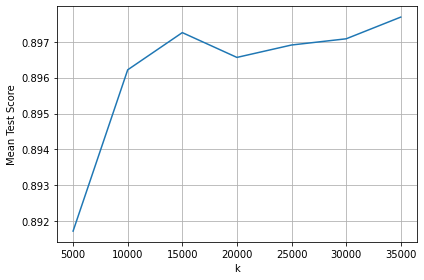

In [ ]:
# Define search parameters
k_grid = np.linspace(5000, 35000, 7, dtype=int)
pipe_params = {
    "selecter__k" : k_grid,
}

# Create pipeline
vectorizer = CountVectorizer(stop_words=all_stop_words)
normalizer = Normalizer()
selecter = SelectKBest(chi2)
naive_bayes_model = NaiveBayes(alpha = 0.01, prior="uniform")

pipe = Pipeline(
    [("vect", vectorizer),  ("norm", normalizer), ("selecter", selecter), ("classify", NaiveBayes())]
)

# Run grid search
grid = model_selection.GridSearchCV(pipe, pipe_params, verbose=1, n_jobs=-1)
grid.fit(X, y)

# Plot results
save_fig = True
fig, ax = plt.subplots()
ax.plot(k_grid, grid.cv_results_["mean_test_score"])
ax.set_xlabel("k")
ax.set_ylabel("Mean Test Score")
ax.grid()

ax2 = ax.twinx()
ax2.plot(k_grid, grid.cv_results_["mean_fit_time"], color="r", linestyle="--")
ax2.set_ylabel("Mean Fit Time [s]")
if save_fig:
  plt.tight_layout()
  plt.savefig("k_grid_search.pdf", bbox_inches="tight", pad_inches=0)

# Some results on selecting the best features

     words       scores
0    anime  1149.849797
3     data   849.011706
1      car   559.216325
4     game   437.452248
5  gamedev   331.022750
8  science   302.598381
2     cars   287.490800
7  players   228.164618
9    unity   212.555372
6   nvidia   211.259746


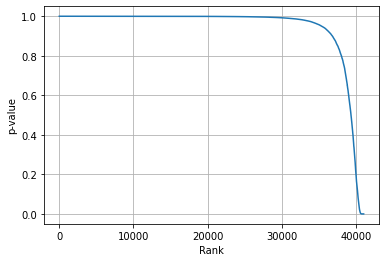

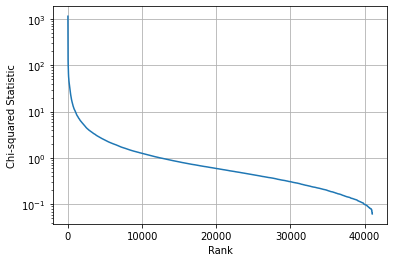

In [ ]:
# Instantiate models
vectorizer = CountVectorizer()
normalizer = Normalizer()
selecter = SelectKBest(chi2)

# Fit and transform variables
X_new = vectorizer.fit_transform(X)
X_new = normalizer.fit_transform(X_new)
X_new = selecter.fit_transform(X_new, y)

# Print the 10 most important words
word_list = np.array(vectorizer.get_feature_names())

selected_words = pd.DataFrame(data={"words" :word_list[selecter.get_support()]})
selected_words["scores"] = selecter.scores_[selecter.get_support()]

print(selected_words.sort_values(by="scores", ascending=False)[0:10])


# Plot p-value of each feature
save_fig = False
fig, ax = plt.subplots()
ax.plot(np.arange(len(selecter.scores_)), sorted(selecter.pvalues_, reverse=True))
ax.set_xlabel("Rank")
ax.set_ylabel("p-value")
ax.grid()
if save_fig:
  plt.tight_layout()
  plt.savefig("p_value.pdf", bbox_inches="tight", pad_inches=0)

save_fig = False
fig, ax = plt.subplots()
ax.plot(np.arange(len(selecter.scores_)), sorted(selecter.scores_, reverse=True))
ax.set_xlabel("Rank")
ax.set_yscale("log")
ax.set_ylabel("Chi-squared Statistic")
ax.grid()
if save_fig:
  plt.tight_layout()
  plt.savefig("chi_squared_stat.pdf", bbox_inches="tight", pad_inches=0)


# Fit best Naive Bayes model

In [ ]:
vectorizer = CountVectorizer(stop_words=all_stop_words)
selecter = SelectKBest(chi2, k=25000)
normalizer = Normalizer()
naive_bayes_model = NaiveBayes(alpha = 0.01, prior="uniform")
pipe = Pipeline(
    [("vect", vectorizer),  ("norm", normalizer), ("selecter", selecter), ("classify", naive_bayes_model)]
)

cross_val_accuracy = model_selection.cross_val_score(pipe, X, y, n_jobs=-1)

print(f"The 5-fold cross-validation accuracy is: {np.mean(cross_val_accuracy):.5f}")


In [ ]:
def store_csv(data, outfile_name):
  """Save file for submission to kaggle"""

  rawdata= {'subreddit':data}
  a = pd.DataFrame(rawdata, columns = ['id','subreddit'])
  a.to_csv(outfile_name,index=True, header=True)
  print ("File saved.")


# Run on test set and save output
pipe.fit(X, y)
print(f"The training accuracy is: {pipe.score(X, y):.5f}")

y_pred = pipe.predict(X_test)

store_csv(y_pred,"naive_bayes.csv")



0.9856674149542394
File saved.


# Run grid search to determine best parameters for a Support Vector Machine, chosen as the "other" classifier

In [ ]:
pipe_params = {
    "vectorizer__stop_words": [None, all_stop_words],
    "vectorizer__ngram_range": [(1,1), (1,2), (1,3)],
    "classify__gamma" : np.logspace(-3, 1, 5), 
    "classify__C" : np.logspace(0, 4, 5)
}

vectorizer = TfidfVectorizer()
normalizer = Normalizer()
svm_model = svm.SVC(kernel="rbf")

pipe = Pipeline(
    [
        ("vect", vectorizer),
        ("norm", Normalizer()),
        ("classify", svm_model()),
    ]
)

grid = model_selection.GridSearchCV(pipe, pipe_params, verbose=2, n_jobs=7)

grid.fit(X, y)

print(f"The best accuracy is {grid.best_score_}.")
print(f"The winning parameters are {grid.best_params_}")

# Fit best SVM model

In [ ]:
vectorizer = TfidfVectorizer(stop_words=all_stop_words, ngram_range=(1,2))
normalizer = Normalizer()
svm_model = svm.SVC(kernel="rbf", gamma=0.1, C=10)
pipe = Pipeline(
    [("vect", vectorizer), ("norm", normalizer), ("classify", svm_model)]
)

cross_val_accuracy = model_selection.cross_val_score(pipe, X, y, n_jobs=-1)

print(np.mean(cross_val_accuracy))

0.8979446428478252
